Simple Example
=====

Approximating a simple intractable distribution: Gaussian with a Gaussian prior on it's log variance. Approximation is with a Gaussian.

In [1]:
# %load ../examples/black_box_svi.py
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import holoviews as hv
%load_ext holoviews.ipython

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad

/home/gavin/.conda/envs/bbsvi/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# %load ../examples/optimizers.py
from __future__ import absolute_import

import autograd.numpy as np
from builtins import range

def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        if callback: callback(x, i, g)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x -= step_size*mhat/(np.sqrt(vhat) + eps)
    return x

In [3]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [4]:
# Specify an inference problem by its unnormalized log-posterior.
D = 2
def log_posterior(x, t):
    """An example 2D intractable distribution:
    a Gaussian evaluated at zero with a Gaussian prior on the log-variance."""
    mu, log_sigma = x[:, 0], x[:, 1]
    prior       = norm.logpdf(log_sigma, 0, 1.35)
    likelihood  = norm.logpdf(mu,        0, np.exp(log_sigma))
    return prior + likelihood

In [5]:
# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_posterior, D, num_samples=2000)

In [6]:
def isocontours(func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=512):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    return Z

In [7]:
def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

    plt.cla()
    target_distribution = lambda x : np.exp(log_posterior(x, t))
    plot_isocontours(ax, target_distribution)

    mean, log_std = unpack_params(params)
    variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
    plot_isocontours(ax, variational_contour)
    plt.draw()
    plt.pause(1.0/30.0)

In [8]:
target = lambda x: np.exp(log_posterior(x, 1))
Z = isocontours(target)

:Overlay
   .Image.I :Image   [x,y]   (z)
   .Level.I :NdOverlay   [Levels]
      :Contours   [x,y]   (z)
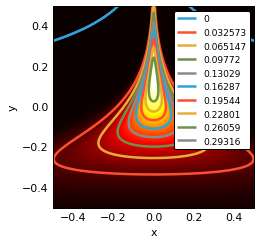

In [9]:
target_distribution = hv.Image(Z)
hv.operation.contours(target_distribution, levels=np.linspace(0,max(Z.ravel()),10))

In [10]:
init_mean    = -1 * np.ones(D)
init_log_std = -5 * np.ones(D)

:Overlay
   .Image.I :Image   [x,y]   (z)
   .Level.I :NdOverlay   [Levels]
      :Contours   [x,y]   (z)
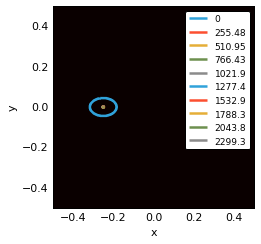

In [11]:
variational_contour = lambda x: mvn.pdf(x, init_mean, np.diag(np.exp(2*init_log_std)))
Z = isocontours(variational_contour)
variational_distribution = hv.Image(Z)
hv.operation.contours(variational_distribution, levels=np.linspace(0,max(Z.ravel()),10))

In [12]:
print("Optimizing variational parameters...")
init_var_params = np.concatenate([init_mean, init_log_std])
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=2000, callback=None)

Optimizing variational parameters...


:Layout
   .Overlay.I :Overlay
      .Image.I :Image   [x,y]   (z)
      .Level.I :NdOverlay   [Levels]
         :Contours   [x,y]   (z)
   .Image.I   :Image   [x,y]   (z)
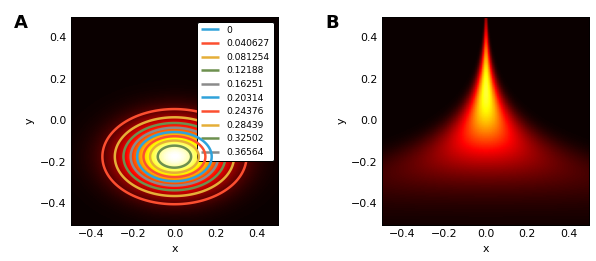

In [13]:
mean, log_std = unpack_params(variational_params)
variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
Z = isocontours(variational_contour)
variational_distribution = hv.Image(Z)
hv.operation.contours(variational_distribution, levels=np.linspace(0,max(Z.ravel()),10))+target_distribution

Bayesian Neural Network
========

Next, fitting a Bayesian neural network in only a few more lines:

In [14]:
def make_nn_funs(layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = sum((m+1)*n for m, n in shapes)

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs

    def logprob(weights, inputs, targets):
        log_prior = -L2_reg * np.sum(weights**2, axis=1)
        preds = predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2, axis=1)[:, 0] / noise_variance
        return log_prior + log_lik

    return num_weights, predictions, logprob

In [15]:
np.einsum?

In [16]:
def build_toy_dataset(n_data=40, noise_std=0.1):
    D = 1
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 2, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = np.cos(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 4.0
    inputs  = inputs.reshape((len(inputs), D))
    targets = targets.reshape((len(targets), D))
    return inputs, targets

In [17]:
# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: norm.pdf(x, 0, 1)
sq = lambda x: np.sin(x)
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[1, 10, 10, 1], L2_reg=0.01,
                 noise_variance = 0.01, nonlinearity=rbf)

In [18]:
inputs, targets = build_toy_dataset()
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

:Curve   [x]   (y)
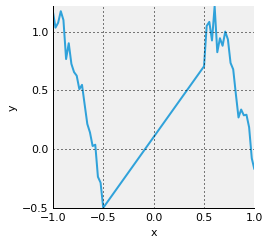

In [19]:
hv.Curve(zip(inputs,targets))

In [20]:
# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_posterior, num_weights,
                                    num_samples=20)

def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))
    
# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -1 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

Isn't this a weird way to store params, why not just put them in a dictionary? Or a list? Would save all these unpacking functions.

Plot some initial samples from the network:

In [21]:
def sample_predictions(params, inputs):
    # Sample functions from posterior.
    #rs = npr.RandomState(0)
    mean, log_std = unpack_params(params)
    sample_weights = rs.randn(10, num_weights) * np.exp(log_std) + mean
    return predictions(sample_weights, inputs)

:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
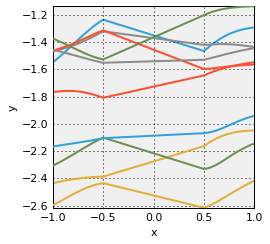

In [22]:
preds = sample_predictions(init_var_params, inputs)
hv.Overlay([hv.Curve(zip(inputs.ravel(), p.ravel())) for p in preds])

In [23]:
print("Optimizing variational parameters...")
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=1000, callback=callback)

Optimizing variational parameters...
Iteration 0 lower bound -23837.841234374875
Iteration 1 lower bound -12701.14040428006
Iteration 2 lower bound -6494.775254425286
Iteration 3 lower bound -3199.9933370789786
Iteration 4 lower bound -2128.848447243119
Iteration 5 lower bound -1348.3834956388228
Iteration 6 lower bound -1597.5828241803504
Iteration 7 lower bound -1132.528361503756
Iteration 8 lower bound -1552.1437784762852
Iteration 9 lower bound -1335.781635000929
Iteration 10 lower bound -1806.9138233170177
Iteration 11 lower bound -1033.30200932555
Iteration 12 lower bound -1322.8110188864136
Iteration 13 lower bound -985.2816716898338
Iteration 14 lower bound -1243.543696364977
Iteration 15 lower bound -1134.8740468318547
Iteration 16 lower bound -1007.1371098072308
Iteration 17 lower bound -1402.0965375185347
Iteration 18 lower bound -1203.0079122657817
Iteration 19 lower bound -1015.571692720415
Iteration 20 lower bound -903.4516405781658
Iteration 21 lower bound -1030.26215262

:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
   .Points.I   :Points   [x,y]
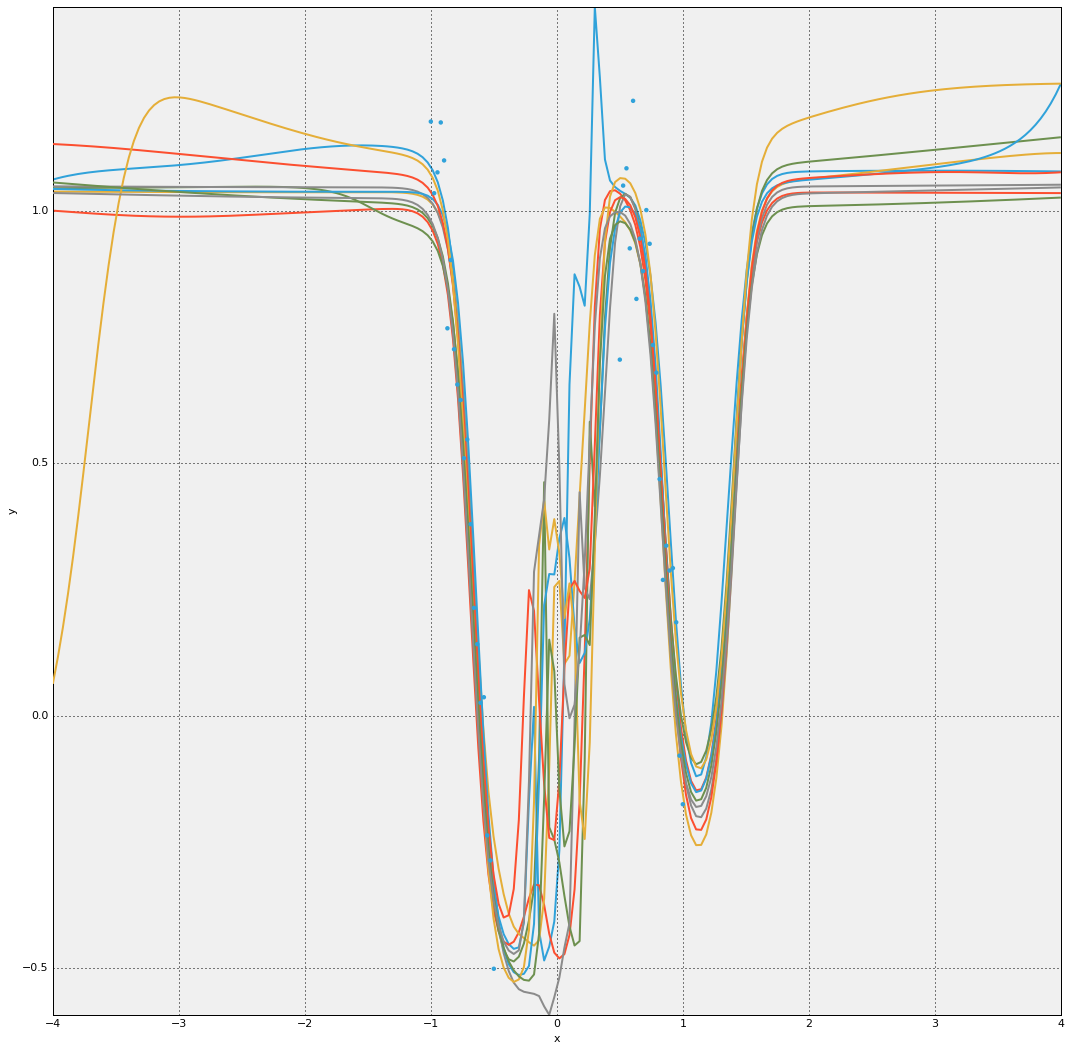

In [24]:
%output size=500
plot_inputs = np.linspace(-4,4,200).reshape(-1,1)
preds = sample_predictions(variational_params, plot_inputs)
hv.Overlay([hv.Curve(zip(plot_inputs.ravel(), p.ravel())) for p in preds])*hv.Points(zip(inputs,targets))